# Machine Learning HW5

### Author: Ze Yang (zey@andrew.cmu.edu)

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import rpy2
%reload_ext rpy2.ipython
import time
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix, auc
from sklearn.decomposition.kernel_pca import KernelPCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from copy import copy
from progressbar import ProgressBar
from tabulate import tabulate


# 1. Text Data

In [2]:
df = pd.read_csv('stories.csv')
stories = df['stories']
df.shape

(102, 2)

## (a) Document-Term Matrix

In [3]:
count_vectorizer = CountVectorizer(token_pattern='[a-zA-Z]+')
term_matrix = count_vectorizer.fit_transform(stories)
names = count_vectorizer.get_feature_names()
n_doc, n_word = term_matrix.shape
print('Number of documents:', n_doc)
print('Number of words:', n_word)

Number of documents: 102
Number of words: 11306


- There are 102 documents and 11306 words in the document-term matrix.

## (b) Histogram of Occurrence

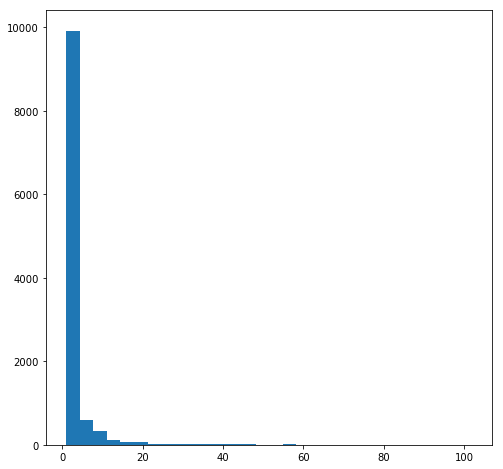

In [4]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
term_matrix_occurrence = np.count_nonzero(
    term_matrix.toarray(), axis=0)
_ = ax.hist(term_matrix_occurrence, bins=30)

In [5]:
max_idx = np.argwhere(
    term_matrix_occurrence==np.max(
        term_matrix_occurrence))
print("Most frequent word:", 
      [names[i[0]] for i in max_idx])
print("Most frequent counts:", 
      np.max(term_matrix_occurrence))

Most frequent word: ['of', 'the']
Most frequent counts: 102


- Most words occur only several times, but some common articles/prepositions appear much more.
- Word "of", "the" appears in most documents (all of the 102 documents).

## (c) Drop Meaningless Words

In [6]:
count_vectorizer = CountVectorizer(
    token_pattern='[a-zA-Z]+',
    stop_words='english',
    min_df=3)
term_matrix = count_vectorizer.fit_transform(stories)
names = count_vectorizer.get_feature_names()
n_doc, n_word = term_matrix.shape
print('Number of documents:', n_doc)
print('Number of words:', n_word)

Number of documents: 102
Number of words: 2378


In [7]:
term_matrix_occurrence = np.count_nonzero(
    term_matrix.toarray(), axis=0)
max_idx = np.argwhere(
    term_matrix_occurrence==np.max(
        term_matrix_occurrence))
print("Most frequent word:", 
      [names[i[0]] for i in max_idx])
print("Most frequent counts:", 
      np.max(term_matrix_occurrence))

Most frequent word: ['s']
Most frequent counts: 96


## (d) Problem for Stemming

In [8]:
names[0:10]

['abc',
 'ability',
 'able',
 'absorbed',
 'abstract',
 'abstraction',
 'abstractions',
 'academic',
 'academy',
 'access']

- The vocabulary has 'abstract', 'abstraction', 'abstractions' that are closely connected. Stemming can reduce these connected word into one single word (maybe "abstract" only).

# 2. Topic Modeling

## (a) Fit LDA

In [9]:
lda = LatentDirichletAllocation(
    n_topics=2, 
    learning_method='batch',
    max_iter=100)
topic_probs = lda.fit_transform(term_matrix)

In [10]:
topics = lda.components_ / lda.components_.sum(
    axis=1)[:, np.newaxis]
print("First Topic top 10 words:", np.array(
    names)[np.argsort(topics[0,:])[0:10]])
print("Second Topic top 10 words:", np.array(
    names)[np.argsort(topics[1,:])[0:10]])

First Topic top 10 words: ['broadcast' 'nominated' 'missed' 'afford' 'southern' 'producers' 'oh'
 'contract' 'programming' 'super']
Second Topic top 10 words: ['alien' 'destroyed' 'physical' 'combining' 'enjoyment' 'sits' 'county'
 'begun' 'professor' 'keen']


## (b) Probabilities over Topics

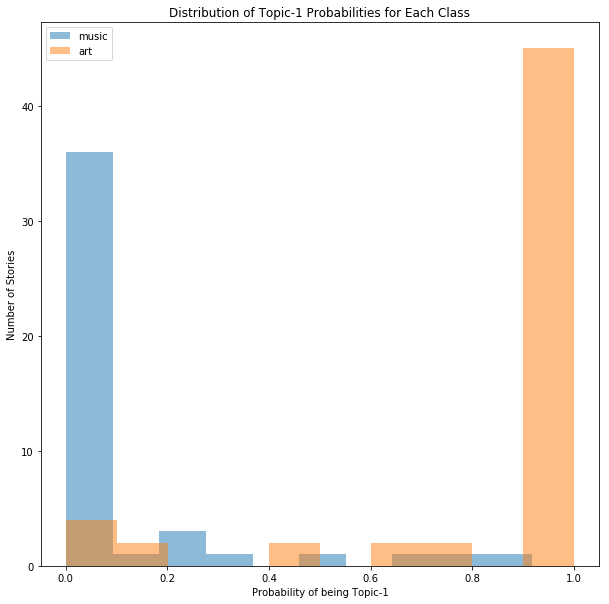

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.hist(topic_probs[:,0][df['class'] == 'music'], bins=10,
  normed=0, alpha=0.5, label='music')
ax.hist(topic_probs[:,0][df['class'] == 'art'], bins=10,
  normed=0, alpha=0.5, label='art')
ax.update({'title': "Distribution of Topic-1 Probabilities for Each Class",
           'xlabel': "Probability of being Topic-1",
           'ylabel': "Number of Stories"})
_ = ax.legend()

In [12]:
df['predicted_topic'] = "art"
df.loc[topic_probs[:,0] < 0.5,'predicted_topic'] = "music"
print("Confusion Matrix:")
print(confusion_matrix(
    df['class'], df['predicted_topic']))
print("Misclassification Error:", 1 - accuracy_score(
    df['class'], df['predicted_topic']))

Confusion Matrix:
[[49  8]
 [ 3 42]]
Misclassification Error: 0.10784313725490191


- The probabilities seem to do a very good job to separate based on document type.
- It assigns high probability of being topic-1 to most "art" labels, while assigns low probability of being topic-1 to most "music" labels.
- The two topics uncovered the underlying "music" and "art" classes. The first topic can be regarded as representing "art", and the second topic represents "music".
- If this were a classifier and we threshold at 0.5, the misclassification error would be 0.1078.

# 3. Distances and Clustering

In [13]:
#To compute distances
from sklearn.metrics.pairwise import euclidean_distances
#To compress a distance matrix into the form scipy requires
from scipy.spatial.distance import squareform
#The actual function that does hierarchical clustering
from scipy.cluster import hierarchy
#The function that thresholds trees to get clusters
from scipy.cluster.hierarchy import cut_tree
from sklearn.feature_extraction.text import TfidfTransformer

## (a) Complete Linkage Clustering

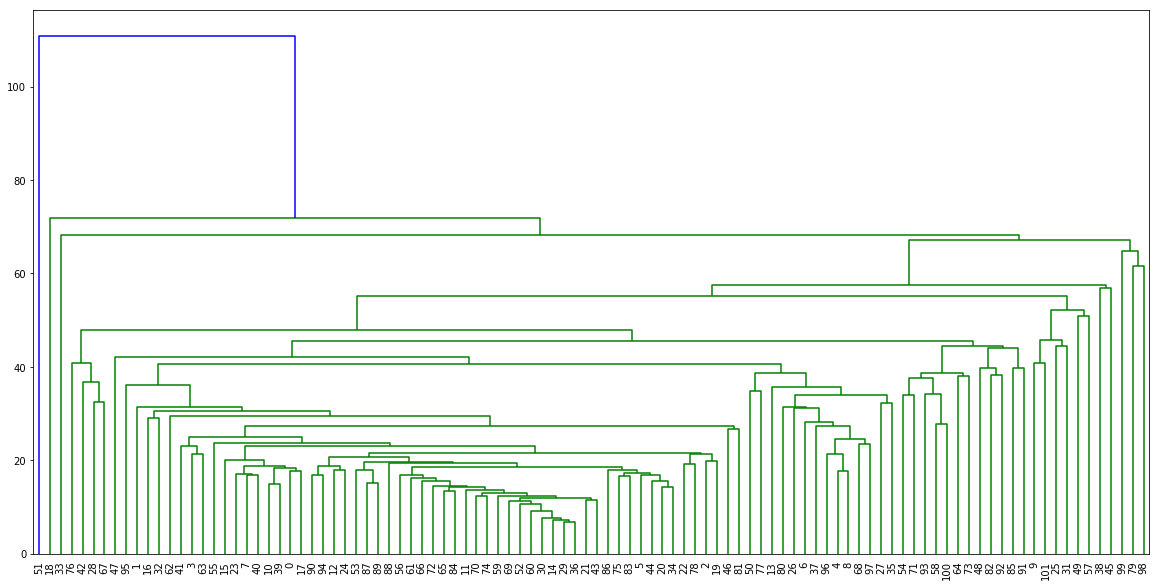

In [40]:
X = term_matrix.toarray()
D = euclidean_distances(X)
#squareform fails if D is slightly asymmetric from precision issues
D = (D + D.T)/2
D = squareform(D)
tree = hierarchy.linkage(D, 'complete')

#Plot the tree
fig, ax = plt.subplots(1,1, figsize=(20,10))
dn = hierarchy.dendrogram(
    tree, leaf_font_size=10)
# cut_tree(tree, n_clusters=4)

- The tree does not look good, the clusterings are not obvious.
- There is an outlier, as shown by the leaf index, it's the No.51 story.

In [49]:
df['story_len'] = df['stories'].apply(len)
print("Mean story length: %.1f" % np.mean(df['story_len']))
print("Max story length:", np.max(df['story_len']))
print("Outlier story length:", df['story_len'][51])

Mean story length: 4107.2
Max story length: 17014
Outlier story length: 17014


- The average story length is 4107.2 characters, but the outlier has 17014 characters, which is the maximum, and more than 4 times the average.
- Since the hierarchy clustering outlier "happpens" to also be an outlier in story length, we might be able to fix the hierarchy clustering by normalizing the story length.

## (b) Fix the Story Length

In [52]:
pd.crosstab?

/Users/zed/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


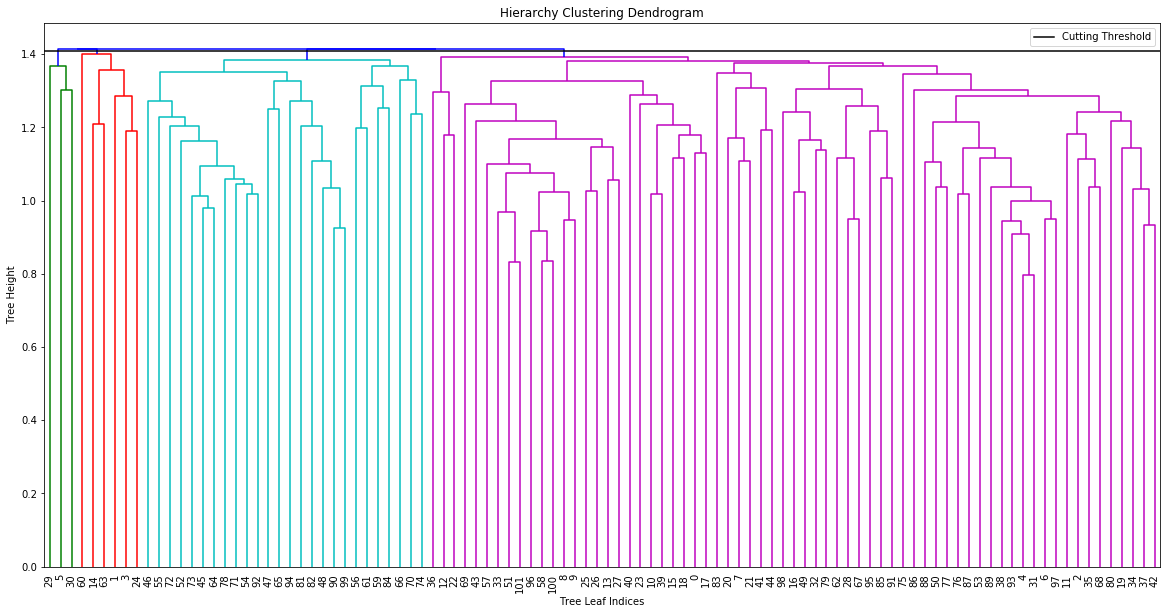

In [86]:
tfidf = TfidfTransformer(use_idf=False)
X2 = tfidf.fit_transform(X)
D2 = euclidean_distances(X2)
D2 = (D2 + D2.T)/2
D2 = squareform(D2)
tree2 = hierarchy.linkage(D2, 'complete')

#Plot the tree
fig, ax = plt.subplots(1,1, figsize=(20,10))
dn2 = hierarchy.dendrogram(
    tree2, leaf_font_size=10,
    color_threshold=1.41,
    ax=ax)
ax.axhline(1.41, color='black', 
           label='Cutting Threshold')
ax.update({
    'title': 'Hierarchy Clustering Dendrogram',
    'xlabel': 'Tree Leaf Indices',
    'ylabel': 'Tree Height',
})
_ = ax.legend()

In [55]:
df['cluster_2'] = cut_tree(tree2, n_clusters=2)
pd.crosstab(df['class'], df['cluster_2'])

cluster_2,0,1
class,,
art,55,2
music,38,7


**The Dendrogram**:
- The tree still does not look like reasonable clustering, but it has been improved a lot from the first tree. In particular:
- The outliers are gone. Most leaves in this tree now has reasonable tree-height that are not too faraway from each other.

**The Cross-Tabulate**:
- The clustering is poor, it's basicly assign more "0"s to both classes.
- True labels are not identifiable by clusters.

## (c) Other Distances

### Method 1: 'ward'

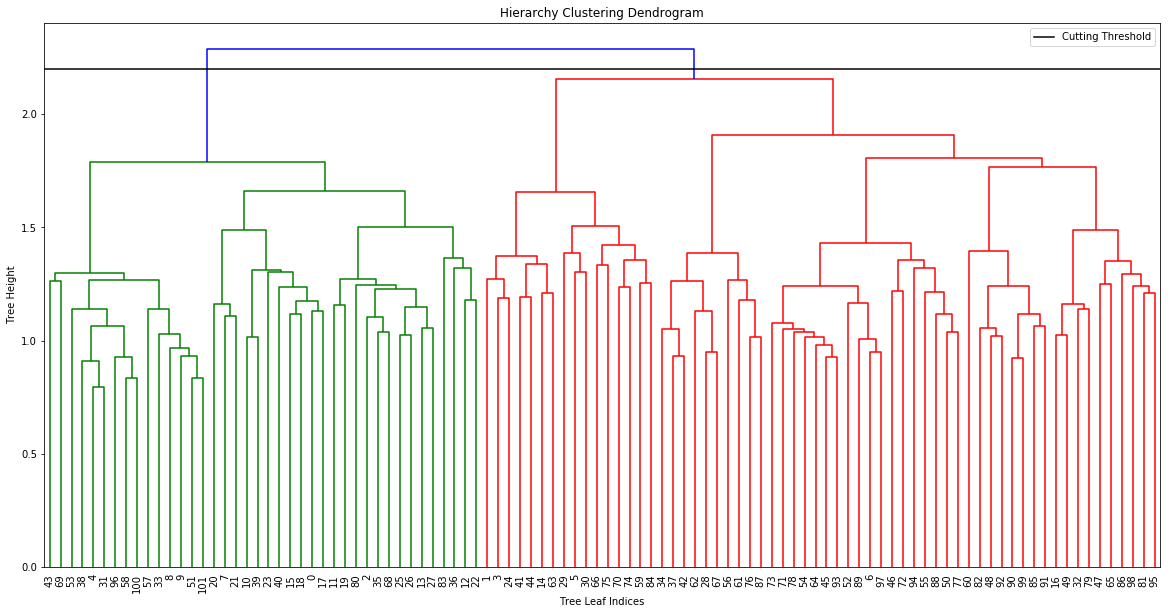

In [71]:
D3 = euclidean_distances(X2)
D3 = (D3 + D3.T)/2
D3 = squareform(D3)
tree3 = hierarchy.linkage(D3, 'ward')

#Plot the tree
fig, ax = plt.subplots(1,1, figsize=(20,10))
dn3 = hierarchy.dendrogram(
    tree3, leaf_font_size=10,
    color_threshold=2.2,
    ax=ax)
ax.axhline(2.2, color='black', 
           label='Cutting Threshold')
ax.update({
    'title': 'Hierarchy Clustering Dendrogram',
    'xlabel': 'Tree Leaf Indices',
    'ylabel': 'Tree Height',
})
_ = ax.legend()

In [58]:
df['cluster_3'] = cut_tree(tree3, n_clusters=2)
pd.crosstab(df['class'], df['cluster_3'])

cluster_3,0,1
class,,
art,11,46
music,29,16


### Method 2: 'ward' & 'use_idf=True'

/Users/zed/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


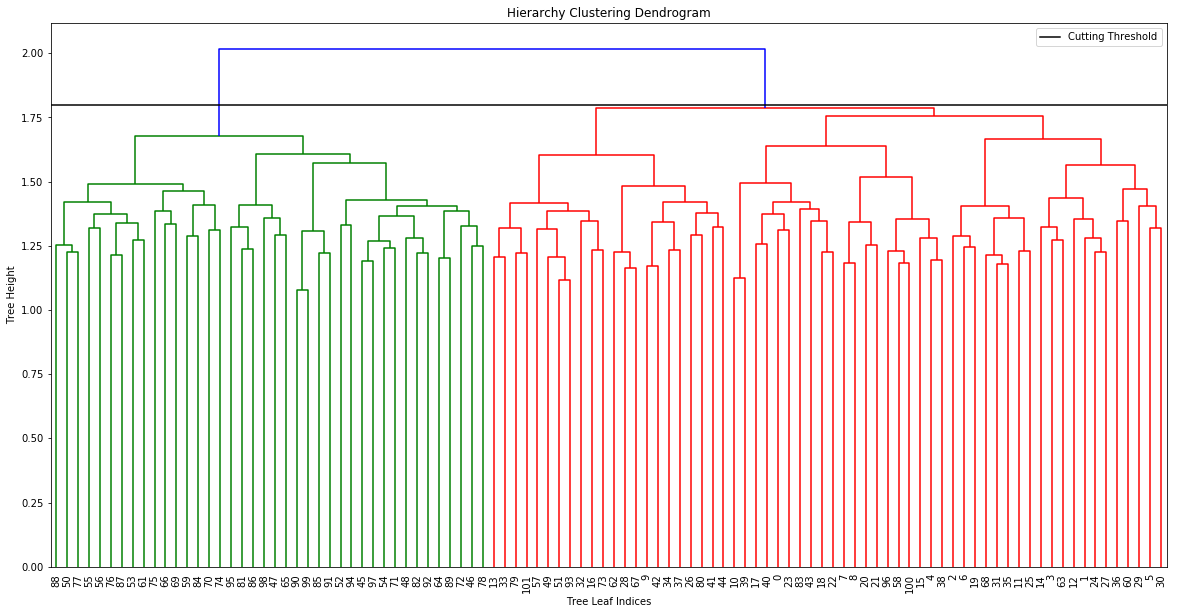

In [67]:
tfidf = TfidfTransformer(use_idf=True)
X4 = tfidf.fit_transform(X)
D4 = euclidean_distances(X4)
D4 = (D4 + D4.T)/2
D4 = squareform(D4)
tree4 = hierarchy.linkage(D4, 'ward')

#Plot the tree
fig, ax = plt.subplots(1,1, figsize=(20,10))
dn4 = hierarchy.dendrogram(
    tree4, leaf_font_size=10, 
    color_threshold=1.8,
    ax=ax)
ax.axhline(1.8, color='black', 
           label='Cutting Threshold')
ax.update({
    'title': 'Hierarchy Clustering Dendrogram',
    'xlabel': 'Tree Leaf Indices',
    'ylabel': 'Tree Height',
})
_ = ax.legend()

In [60]:
df['cluster_4'] = cut_tree(tree4, n_clusters=2)
pd.crosstab(df['class'], df['cluster_4'])

cluster_4,0,1
class,,
art,17,40
music,45,0


- The second method does best at separating the articles.
- If they were classifers, and cluster-0 represents "music": 
    - The accuracy score of the first method is 73.52%
    - The accuracy score of the second method is 83.33%